In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Embedding
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import mean_squared_error

In [54]:
rnafold = pd.read_csv('datasets/yuanli.csv')
rnafold['sequence'] = rna['53-syn-domain'] + rna['A'] + rna['B'] + rna['40-syn-domain']

In [15]:
#rnafold = pd.read_csv('datasets/rnacofold.csv')
#rnafold['sequence'] = rnafold['crRNA'] + rnafold['tracrRNA']

In [55]:
rnafold = rnafold.dropna()

In [56]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
rnafold['words'] = rnafold.apply(lambda x: getKmers(x['sequence']), axis=1)
texts = list(rnafold['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

In [57]:
cv = CountVectorizer()
X = cv.fit_transform(texts).toarray()
y = rnafold['fluo_8h']
num_classes = 3
yc = pd.qcut(y, num_classes, labels=False)
yh = to_categorical(yc)

### Classification

#### Multi-layer Perceptrons

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, yh, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31, 66) (8, 66) (31, 3) (8, 3)


In [59]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               6700      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 303       
Total params: 7,003
Trainable params: 7,003
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 0.5632 - accuracy: 0.7419
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.5423 - accuracy: 0.7742
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 0.5147 - accuracy: 0.7742
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.4831 - accuracy: 0.8065
Epoch 5/5
1/1 [==============================] - 0s 14ms/step - loss: 0.4514 - accuracy: 0.8065


In [63]:
_, acc = model.evaluate(X_test, y_test, verbose=1)
print("accuracy = " + str(acc))

1/1 [==============================] - 0s 21ms/step - loss: 0.7406 - accuracy: 0.2500
accuracy = 0.25


#### CNN

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31, 66, 1) (8, 66, 1) (31, 1) (8, 1)


In [65]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 64, 64)            256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               198500    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [66]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
1/1 [==============================] - 1s 536ms/step - loss: 0.0000e+00 - accuracy: 0.3226
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 3/5
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 4/5
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 5/5
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 0.3548


0.125

#### RNN

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31, 66, 1) (8, 66, 1) (31, 1) (8, 1)


In [68]:
model = Sequential()
'''
top_words = 5000
max_review_length = 500
embedding_vecor_length = 32
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
'''
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
#model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
#model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 2/5
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 3/5
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 4/5
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 0.3548
Epoch 5/5
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - accuracy: 0.3548


0.25

### Regression

#### CNN

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31, 66, 1) (8, 66, 1) (31, 1) (8, 1)


In [71]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 64, 64)            256       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 62, 64)            12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               198500    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [72]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 0s 6ms/step - loss: 38684.4766
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 34233.0742
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 32249.3066
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 30188.4336
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 29781.8262
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 30013.3945
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 29028.1582
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 28671.6895
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 28990.7090
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 27811.0059
Epoch 11/100
7/7 [==============================] - 0s 7ms/step - loss: 27688.5586
Epoch 12/100
7/7 [==============================] - 0s 8ms/step - loss: 27300.0527
Epoch 13/100

7/7 [==============================] - 0s 7ms/step - loss: 965.0892


0.6088269928339523


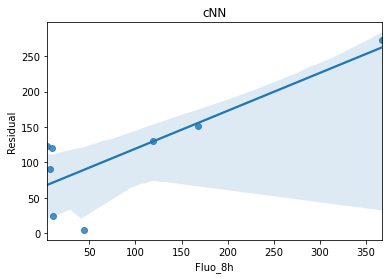

In [73]:
from sklearn.metrics import r2_score
sns.regplot(y_test, y_pred)
#plt.axhline(y=0, color='r', linestyle='-')
plt.title('cNN')
print(r2_score(y_test, y_pred))
#plt.xticks(rotation=90)
plt.xlabel('Fluo_8h')
plt.ylabel('Residual')
plt.show()

#### RNN

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31, 66, 1) (8, 66, 1) (31, 1) (8, 1)


In [75]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
7/7 [==============================] - 2s 27ms/step - loss: 38663.8633
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 38575.8750
Epoch 3/100
7/7 [==============================] - 0s 27ms/step - loss: 38282.2344
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 37902.7070
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 37463.2344
Epoch 6/100
7/7 [==============================] - 0s 28ms/step - loss: 36922.0938
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 36391.1523
Epoch 8/100
7/7 [==============================] - 0s 26ms/step - loss: 35833.4258
Epoch 9/100
7/7 [==============================] - 0s 27ms/step - loss: 35343.6680
Epoch 10/100
7/7 [==============================] - 0s 28ms/step - loss: 34892.2188
Epoch 11/100
7/7 [==============================] - 0s 26ms/step - loss: 34489.7031
Epoch 12/100
7/7 [==============================] - 0s 28ms/step - loss: 34067.9883
E

7/7 [==============================] - 0s 25ms/step - loss: 30391.1738
Epoch 99/100
7/7 [==============================] - 0s 24ms/step - loss: 30386.3750
Epoch 100/100
7/7 [==============================] - 0s 25ms/step - loss: 30383.1738


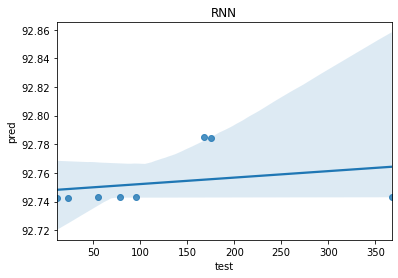

In [77]:
sns.regplot(y_test, y_pred)
#plt.axhline(y=0, color='r', linestyle='-')
plt.title('RNN')
#plt.xticks(rotation=90)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()

### Dataprep

In [ ]:
with open('datasets/output.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+7] for i in range(0, len(output), 7)]
output

In [ ]:
df = pd.DataFrame(output)
df[7] = df[1].str[:-9]
df[1] = df[1].str[-6:-1]
df[2] = df[2].str[-6:-1]
df[3] = df[3].str.replace('frequency of mfe structure in ensemble', '')
df[8] = df[3].apply(lambda x: x.split(';')[0])
df[9] = df[3].apply(lambda x: x.split('=')[1])
df[10] = df[0].apply(lambda x: x.split('&')[0])
df[11] = df[0].apply(lambda x: x.split('&')[1])
numbers = pd.Series(np.arange(len(df))+1).astype(str)
df[12] = 'c' + numbers
df[13] = 't' + numbers
df = df[[12, 10, 13, 11, 7, 1, 2, 8, 9]]
df[[1, 2, 8, 9]] = df[[1, 2, 8, 9]].astype(float)
df[8] = df[8] * 100
df = df.rename(columns={12: 'c_index', 10: 'crRNA', 13: 't_index',
                        11: 'tracrRNA', 7: 'MFE_structures', 1: 'MFE',
                       2: 'free_energy_thermodynamic_ensemble',
                       8: 'frequency_MFR_structures', 9: 'delta_G'})

df

In [ ]:
df.to_csv('datasets/rnacofold.csv', index=False)

### New Dataprep

In [ ]:
with open('datasets/new_seq.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+5] for i in range(0, len(output), 5)]
output

In [ ]:
df = pd.DataFrame(output)
df[11] = df[1].apply(lambda x: (x.split(' ( ')[0]))
df[1] = df[1].apply(lambda x: (x.split(' ( ')[1]).split(')')[0])
df[2] = df[2].apply(lambda x: (x.split(' [ ')[1]).split(']')[0])
df[31] = df[3].apply(lambda x: ((x.split(' { ')[1]).split(' d=')[1]).split('}')[0])
df[32] = df[3].apply(lambda x: (x.split(' { ')[0]))
df[3] = df[3].apply(lambda x: (x.split(' { ')[1]).split(' d=')[0])
df[41] = df[4].apply(lambda x: (x.split(';')[1]).split(' ')[-1])
df[4] = df[4].apply(lambda x: (x.split(';')[0]).split(' ')[-1])
#df[2] = df[1].str[-6:-1]
df

In [ ]:
df = df[[0, 11, 1, 2, 32, 3, 31, 4, 41]]
df = df.rename(columns={0: 'sequence', 11: 'optimal_secondary_structure', 1: 'optimal_mfe',
                       2: 'free_energy_thermo_ensemble', 32: 'centroid_secondary_structure',
                       3: 'centroid_mfe', 31: 'd', 4: 'freq_mfe_structure_in_ensemble', 41: 'ensemble_diversity'})
df

In [ ]:
df.to_csv('datasets/new_seq.csv', index=False)